<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter04/Visualizing_the_filters'_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing the outcome of feature learning
We have learned that filters play a key role in learning the features of an image, which, in turn, help in classifying the image into the right class. However, we haven't mentioned what the filters learn that makes them powerful.  

In this section, we will learn about what these filters learn that enables CNNs to classify an image correctly by classifying a dataset that contains images of X's and O's. We will also examine the fully connected layer (flatten layer) to understand what their activations look like. Let's take a look at what the filters learn

In [1]:
# download the dataset
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2022-02-26 18:27:16--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6025:18::a27d:4512, 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6025:18::a27d:4512|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5jh4hpuk2gcxaaq/all.zip [following]
--2022-02-26 18:27:17--  https://www.dropbox.com/s/raw/5jh4hpuk2gcxaaq/all.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc593bdefaee7719c7d72881bba8.dl.dropboxusercontent.com/cd/0/inline/BgfYbEpTy0YzQ22HBbPIWB0K_wmh7WB_FVNCFoQgPuoeo-Y26jB-FVTZNCP-5J74HNL-r-nf1m4FL-UWXaNYpaW37UmIQXb6uz8jmLwgC5-SAqHYs9EgVLgTOe9bR6KT_pZrm__TPLUZv6IJH4J-jSEn/file# [following]
--2022-02-26 18:27:17--  https://uc593bdefaee7719c7d72881bba8.dl.dropboxusercontent.com/cd/0/inline/BgfYbEpTy0YzQ22HBbPIWB0K_wmh7WB_FVNCFoQgPuoeo-Y26jB-FVTZNCP-5J74HNL-r-nf1m4FL-UWXaNYpa

In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline



In [ ]:
from imgaug import augmenters as iaa
tfm = iaa.Sequential(iaa.Resize(28))

class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [25]:
# using torchvision.transforms
from torchvision import transforms as T
tfm = T.Compose([T.ToPILImage(),
                T.Resize(size=(28,28)),
                T.ToTensor()])

class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm(cv2.imread(f)[:,:,0])
        # im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [26]:
data = XO('./all/*')

In [23]:
len(data.files)

2498

/tmp/ipykernel_193373/2691866421.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)


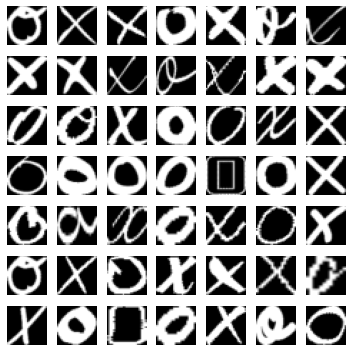

In [27]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [28]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [29]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [30]:
trn_dl = DataLoader(XO('./all/*'), batch_size=32, drop_last=True)

In [31]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [32]:
model, loss_fn, optimizer = get_model()

In [33]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0

In [34]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

/tmp/ipykernel_193373/2691866421.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)


/tmp/ipykernel_193373/2691866421.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)


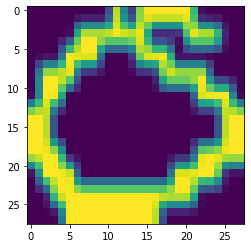

In [35]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

In [36]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

In [37]:
intermediate_output.shape

torch.Size([64, 26, 26])

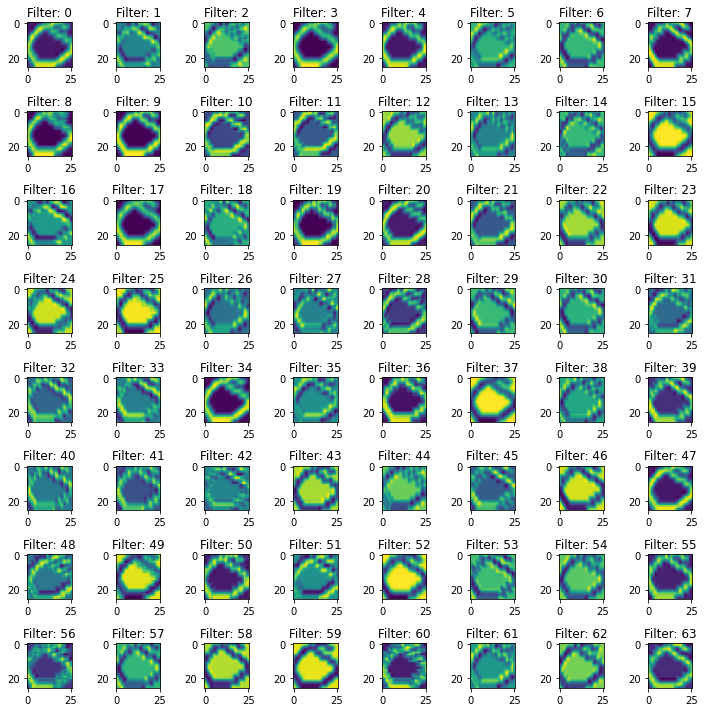

In [38]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [39]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [40]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

In [41]:
second_intermediate_output.shape

torch.Size([128, 11, 11])

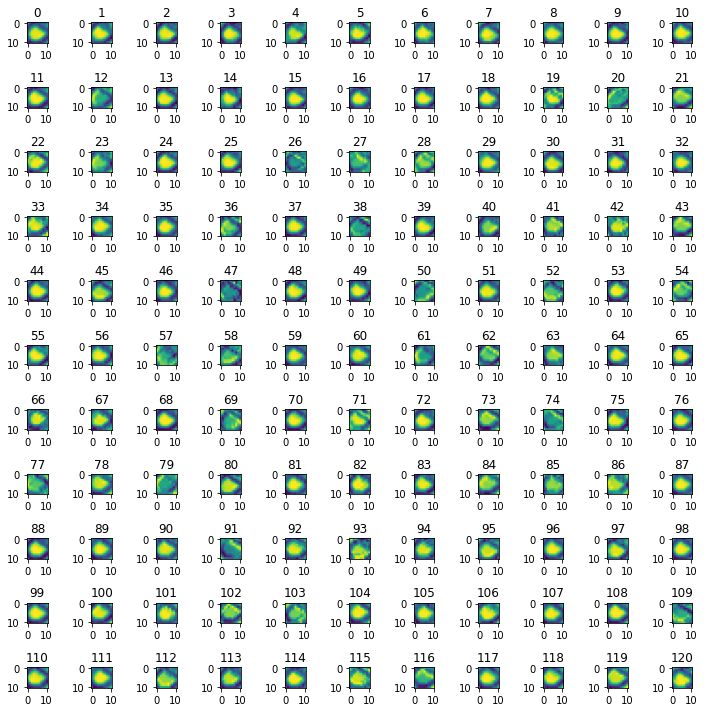

In [42]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [43]:
im.shape

torch.Size([1, 28, 28])

In [44]:
x, y = next(iter(trn_dl))
x2 = x[y==0]
len(x2)

/tmp/ipykernel_193373/2691866421.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)


18

In [45]:
x2 = x2.view(-1,1,28,28)

In [46]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

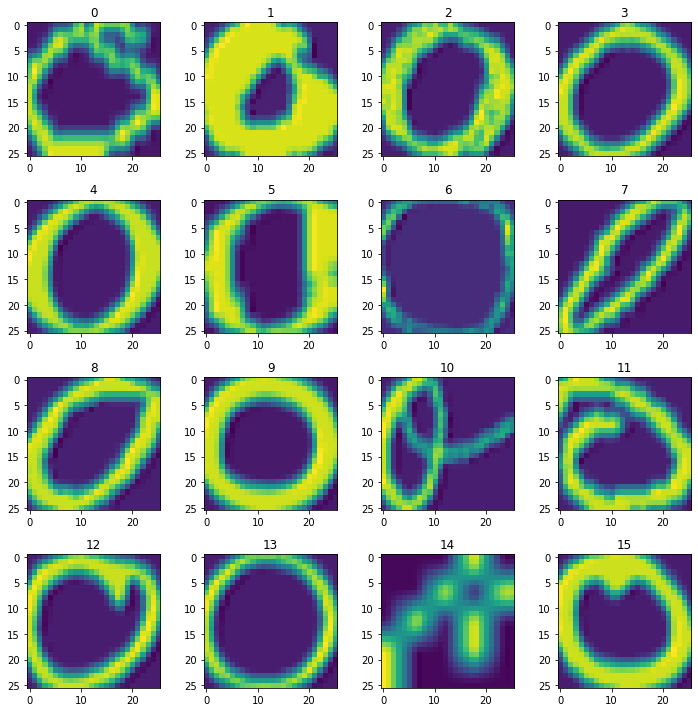

In [47]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [48]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

In [49]:
second_intermediate_output.shape

torch.Size([18, 128, 11, 11])

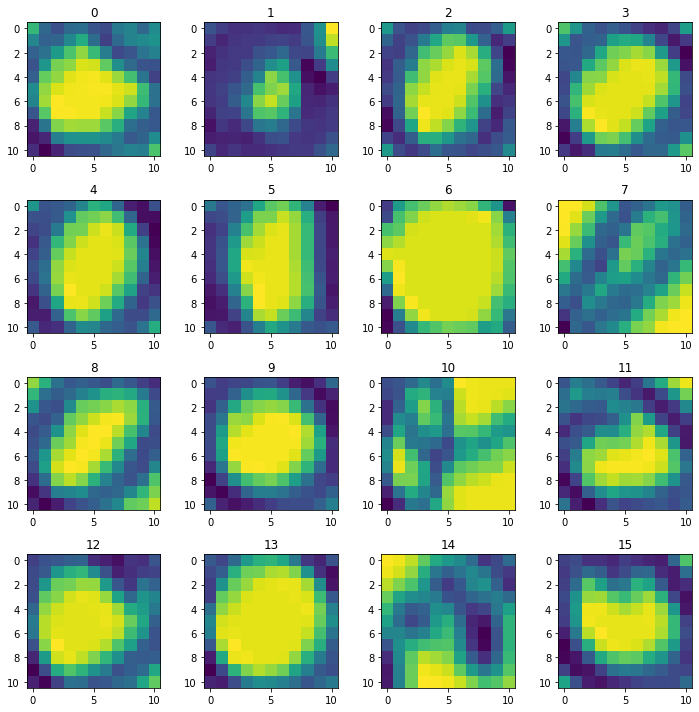

In [50]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [51]:
len(XO('./all/*'))

2498

In [52]:
custom_dl = DataLoader(XO('./all/*'), batch_size=2498, drop_last=True)

In [53]:
x, y = next(iter(custom_dl))

/tmp/ipykernel_193373/2691866421.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)


In [54]:
x2 = x[y==0]

In [55]:
len(x2)

1245

In [56]:
x2 = x2.view(len(x2),1,28,28
             )

In [57]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

In [58]:
flatten_layer_output.shape

torch.Size([1245, 3200])

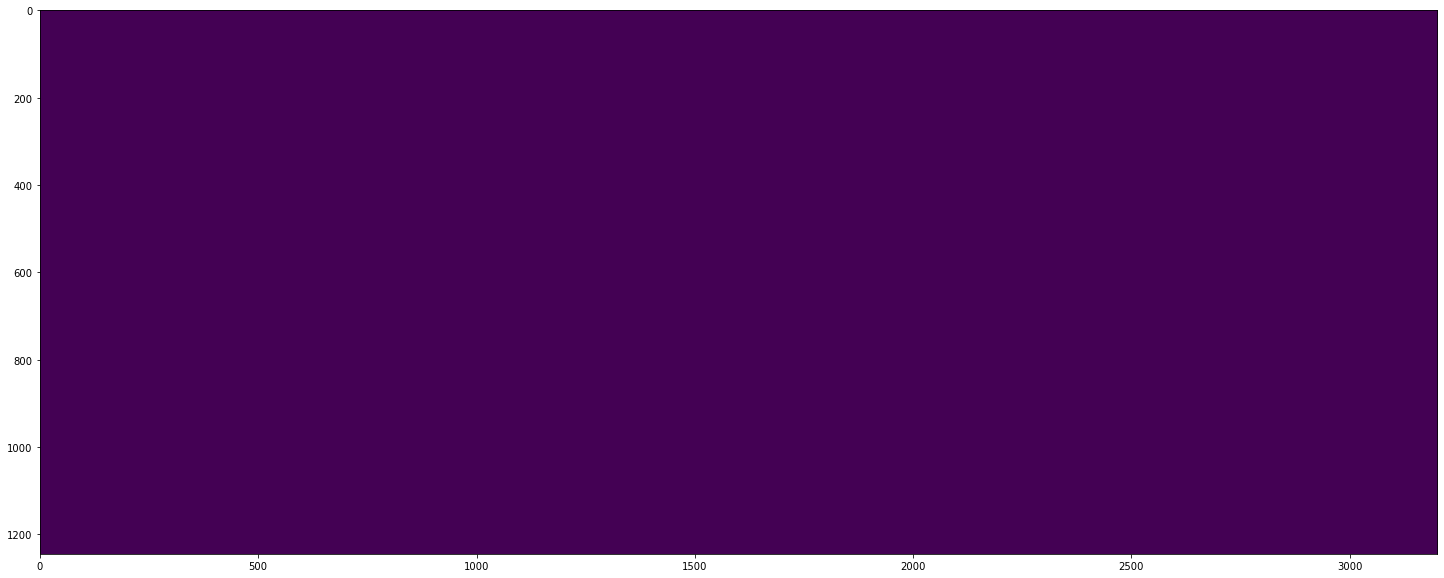

In [60]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())